## Try to see if our S2Si threshold is too high. 
Notebook should work fo runs with trigger on s2, set to 600+mus in buffer

In [1]:
import os
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt

from invisible_cities.cities.irene      import Irene
from invisible_cities.cities.irene_test import unpack_s12params, s12params
from invisible_cities.reco.params   import S12Params as S12P, PMaps, Peak
from invisible_cities.core.ic_types import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.core.configure         import configure
from invisible_cities.reco     import peak_functions_c as cpf
from invisible_cities.reco     import peak_functions   as  pf
from invisible_cities.io       import pmap_io          as pio
from invisible_cities.database import load_db
from invisible_cities.icaro.mpl_functions import circles

In [2]:
run = 4446
DataSensor  = load_db.DataSiPM(run)
DataPmt     = load_db.DataPMT(run)
active_sipm = DataSensor.Active.values
active_pmt  = DataPmt.Active.values

#### Housekeeping

In [3]:

ic_data = os.path.join(os.environ['IC_DATA'])
rwf_path  = ic_data + 'LSC/wvfms/{}/dst_waves.gdcsnext.1841_{}.root.h5'.format(run,run)
conf_path = '/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/config/irene.conf'

In [4]:
# initialize irene
PATH_IN  = os.path.join(rwf_path)
PATH_OUT = os.path.join('electrons_40keV_z250_CWF.h5')
conf     = configure(('dummy ' + conf_path).split()).as_dict
conf.update(dict(run_number = 0,
                 filesin    = PATH_IN,
                 file_out   = PATH_OUT,
                 nmax       = 100000,
                 **unpack_s12params(s12params())))
irene = Irene(**conf)

In [5]:
# Creates a random sorted list of non-repeating valid event numbers
def sample_events(n_sample_events, rwf_path, all_events=False):
    ev_sample = []
    with tb.open_file(rwf_path, 'r+') as f_rwfs:
        events = [f_rwfs.root.Run.events[i][0] for i in range(len(f_rwfs.root.Run.events[:]))]
        if all_events: return events
        ev_sample = np.random.choice(events[1:-1], size=n_sample_events-2, replace=False)
        ev_sample = np.append(np.insert(ev_sample, 0, events[0]), events[-1])
        ev_sample.sort()
        return ev_sample
    
# Get csums for events of pmts and sipms
def calibrated_waveforms(events, irene, rwf_path, pmts=True, sipms=True):
    with tb.open_file(rwf_path ,'r') as f:
        CSUMs  = {}
        csipm  = {}
        for ev in events:
            if pmts : CSUMs[ev] = irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0]
            if sipms: csipm[ev] = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[ev]).sum(axis=0)
    return CSUMs, csipm

# Mod from invisible_cities.icaro.pmaps_mpl
def plot_s2si_peak_map(s2si_peak, cmap='Blues', subplot=-1, colorbar=True):
        """Plot a map of the energies of S2Si objects."""

        DataSensor = load_db.DataSiPM(0)
        radius = 2
        xs  = DataSensor.X.values[list(s2si_peak.keys())]
        ys  = DataSensor.Y.values[list(s2si_peak.keys())]
        col = [s2si_peak[sipm].sum() for sipm in s2si_peak]
        r   = np.ones(len(xs)) * radius
        
        if subplot !=-1: plt.subplot(subplot, aspect="equal")
        else           : plt.subplot(         aspect="equal")
        circles(xs, ys, r, c=col, alpha=1, ec="none", cmap=cmap)
        if colorbar: plt.colorbar()

        plt.xlim(-250, 250) # this should be fixed in nextic/master
        plt.ylim(-250, 250)

#### First plot some summed S2s when thr_sipm is set to different values

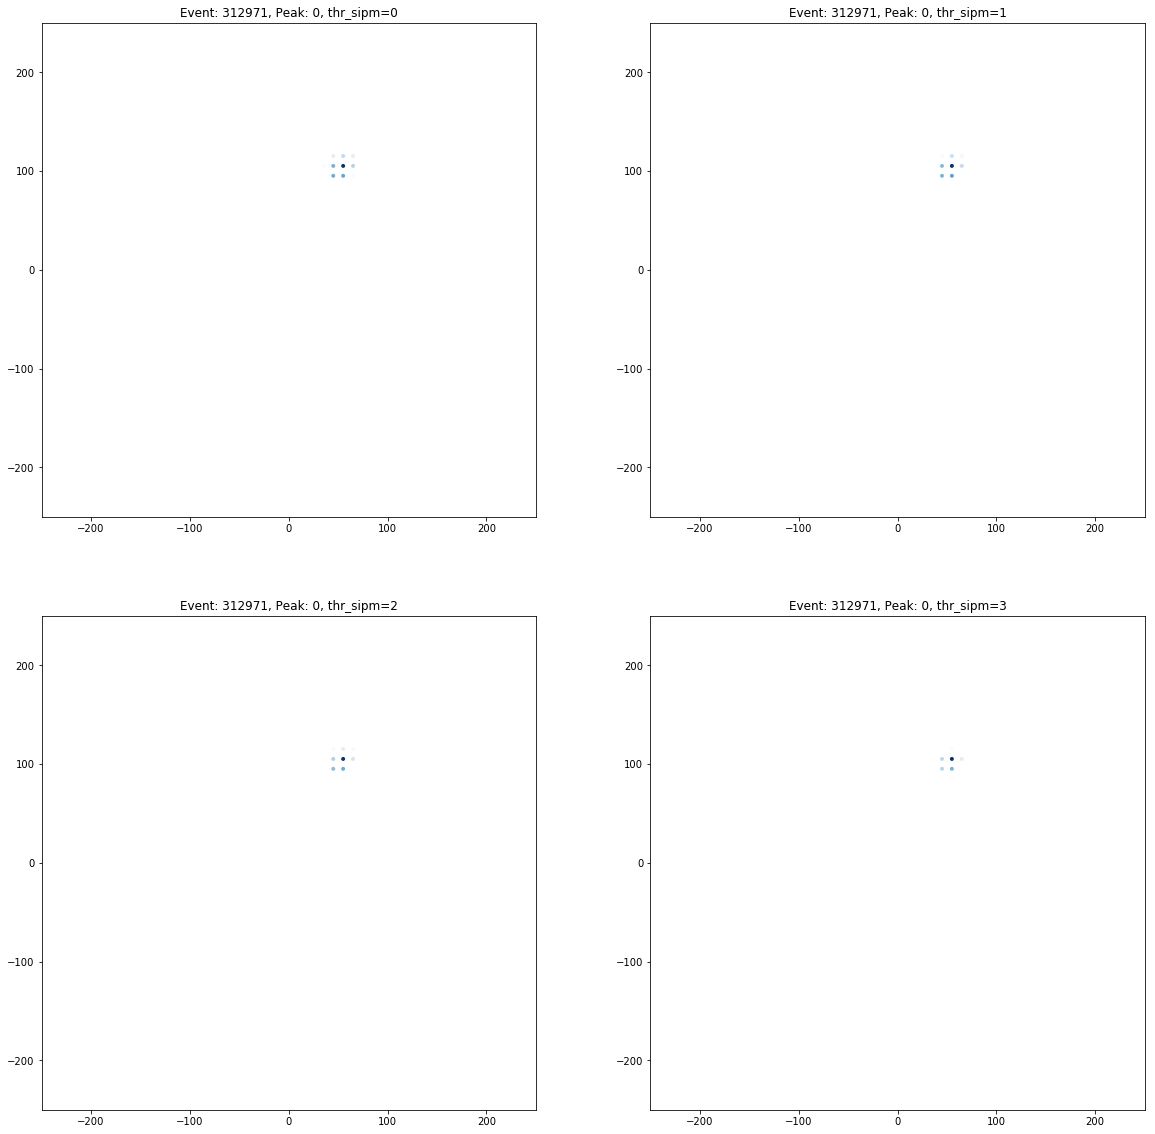

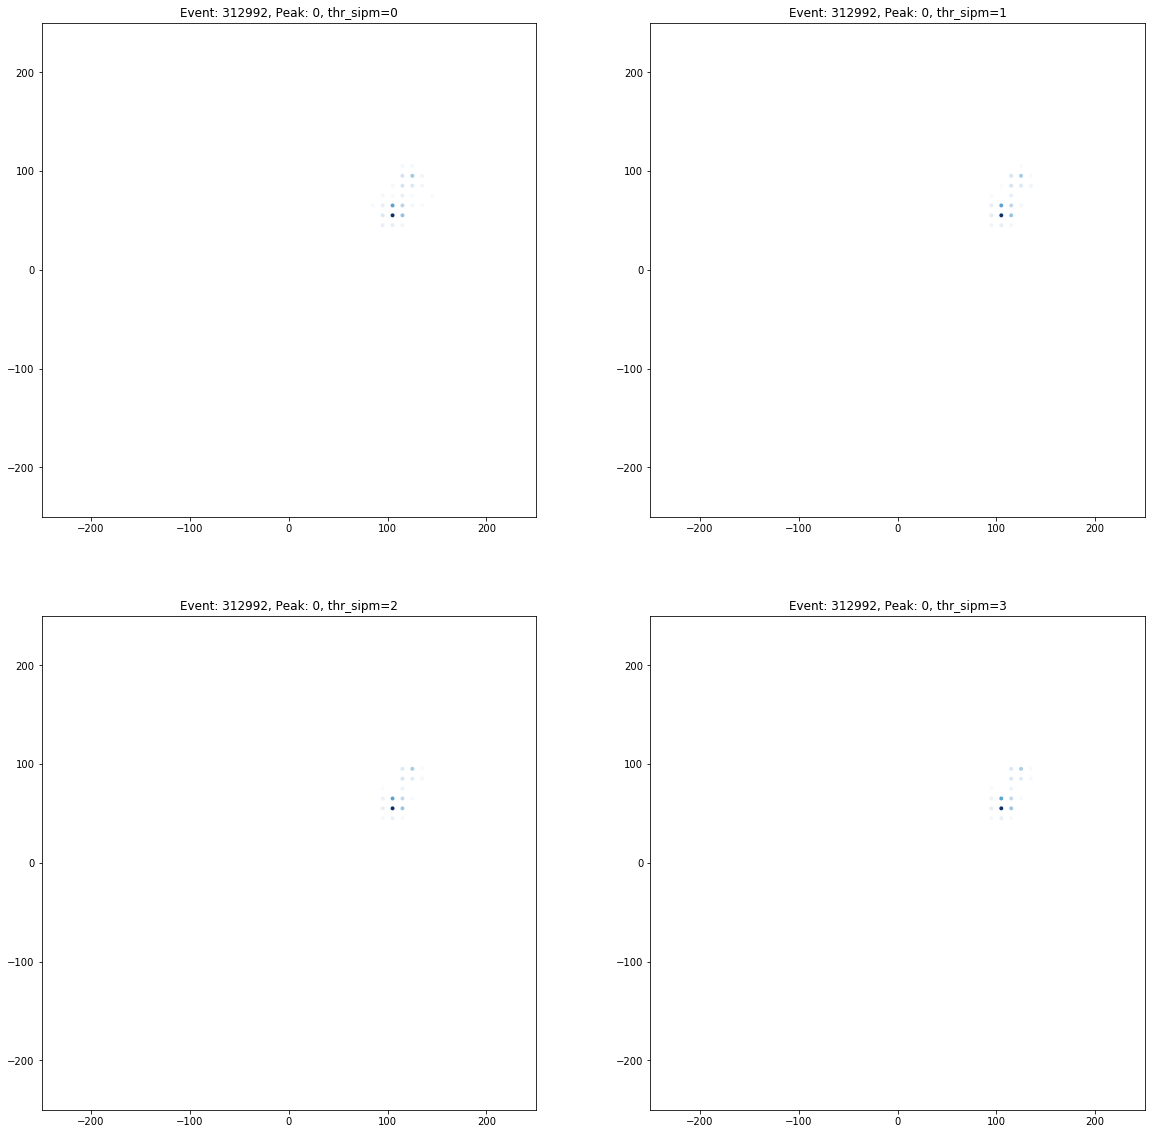

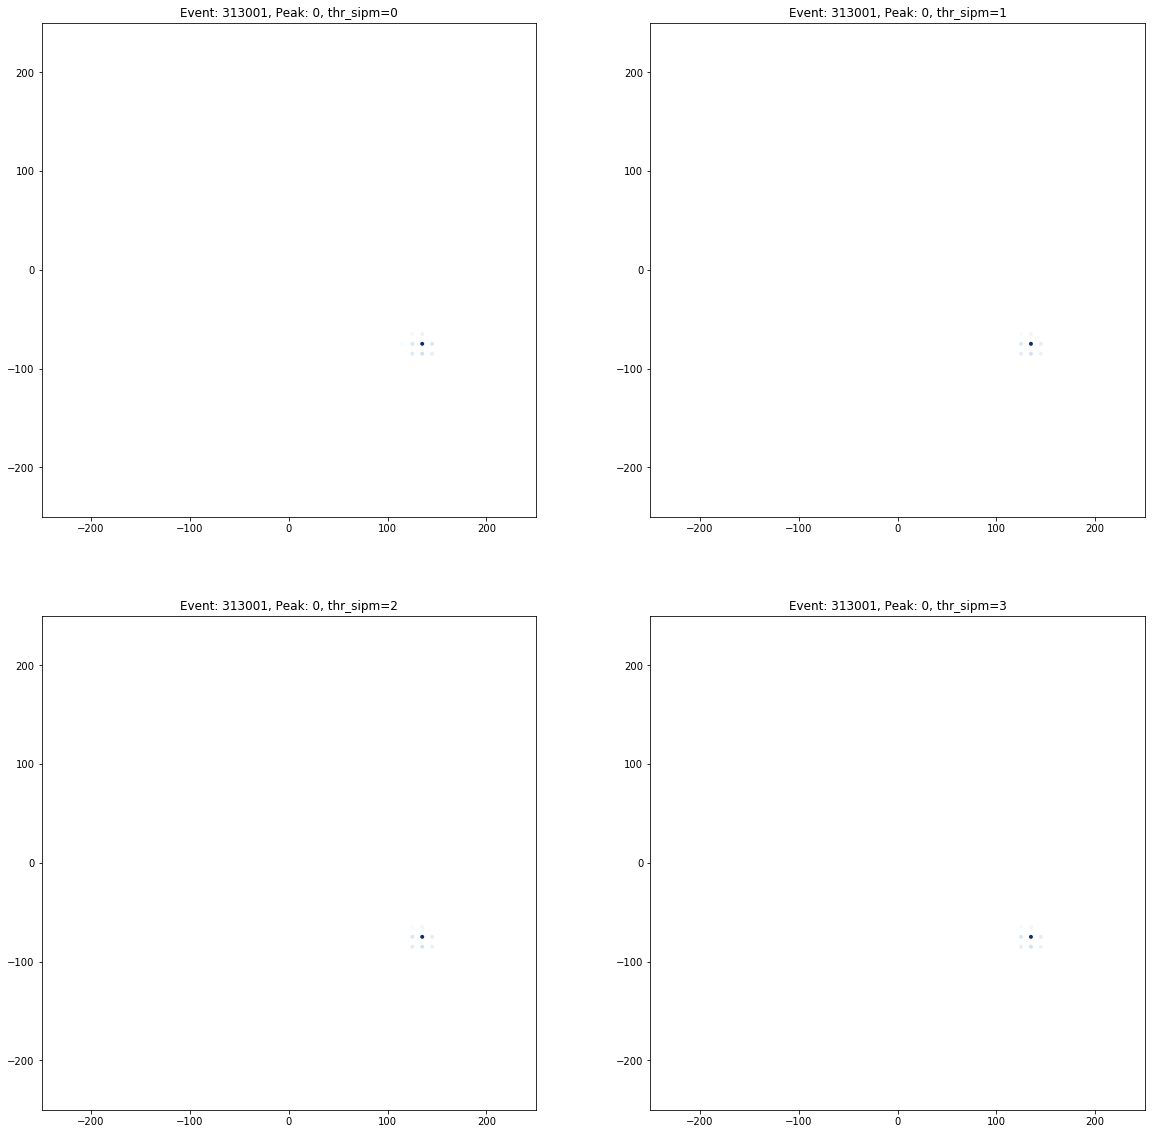

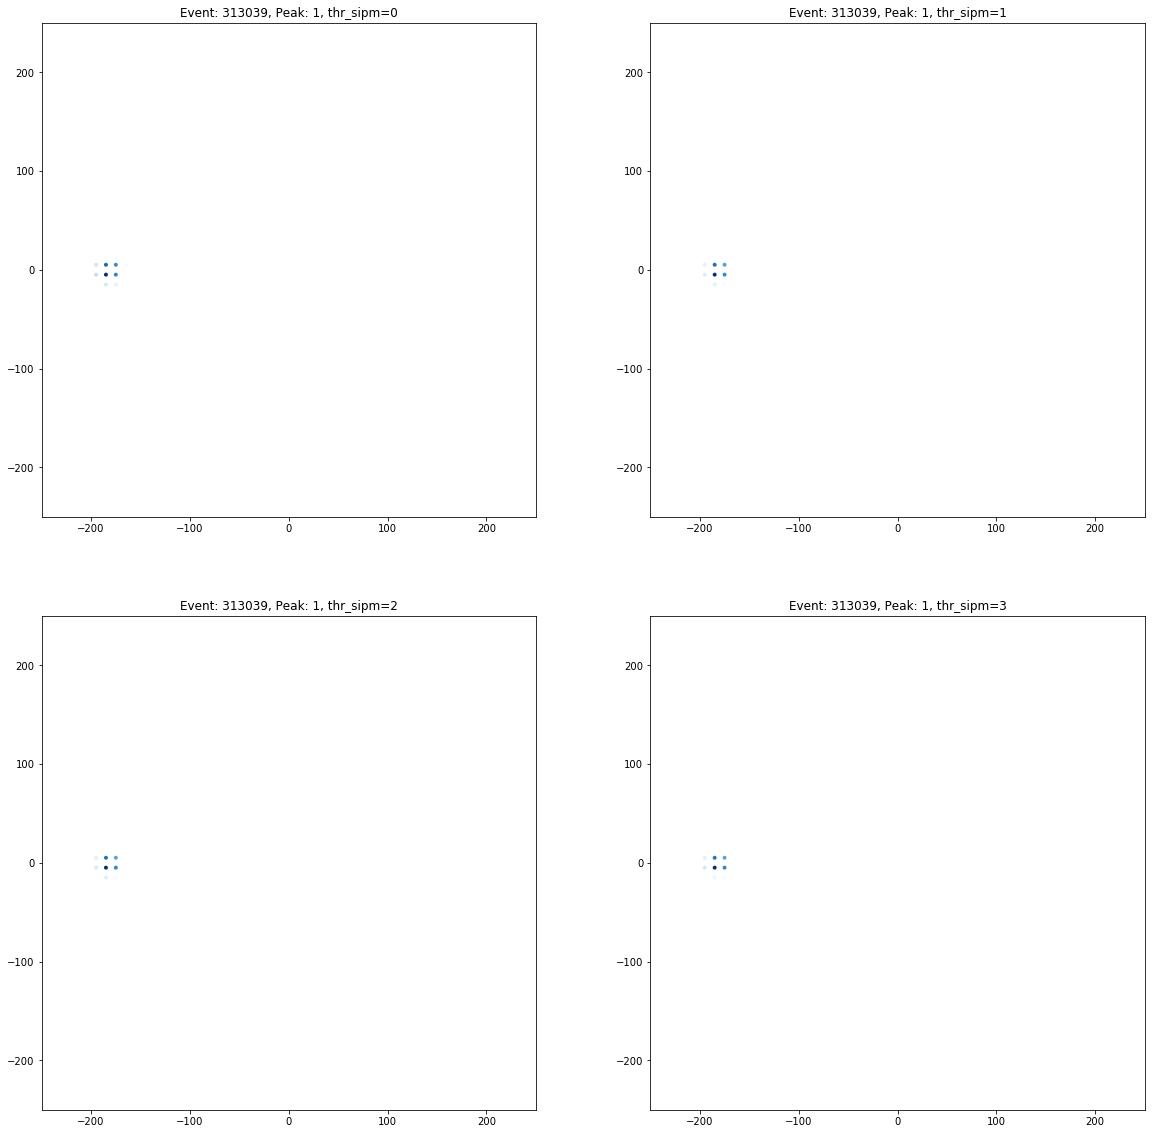

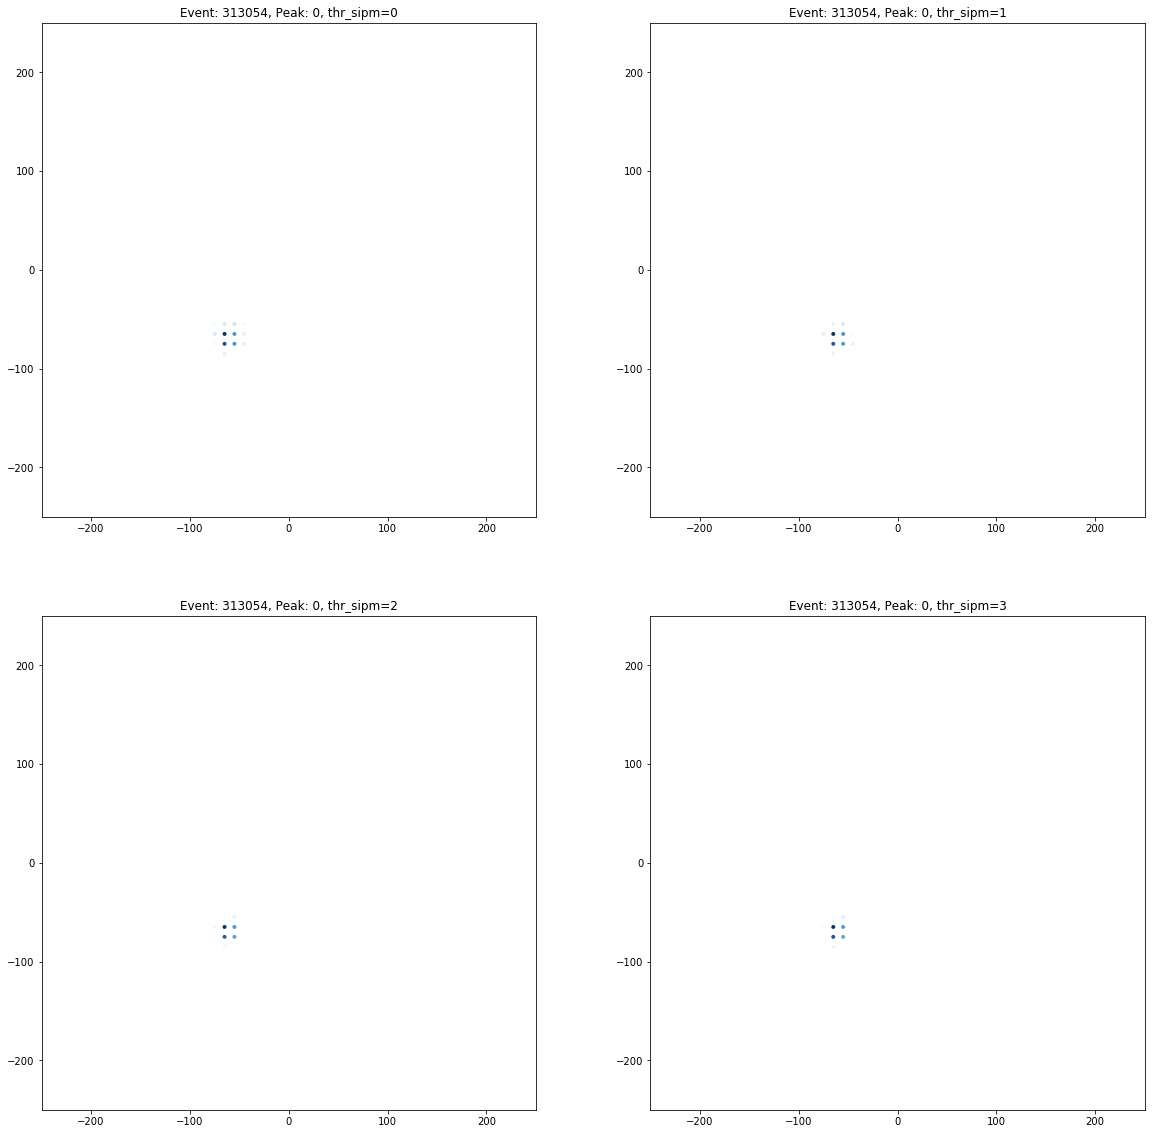

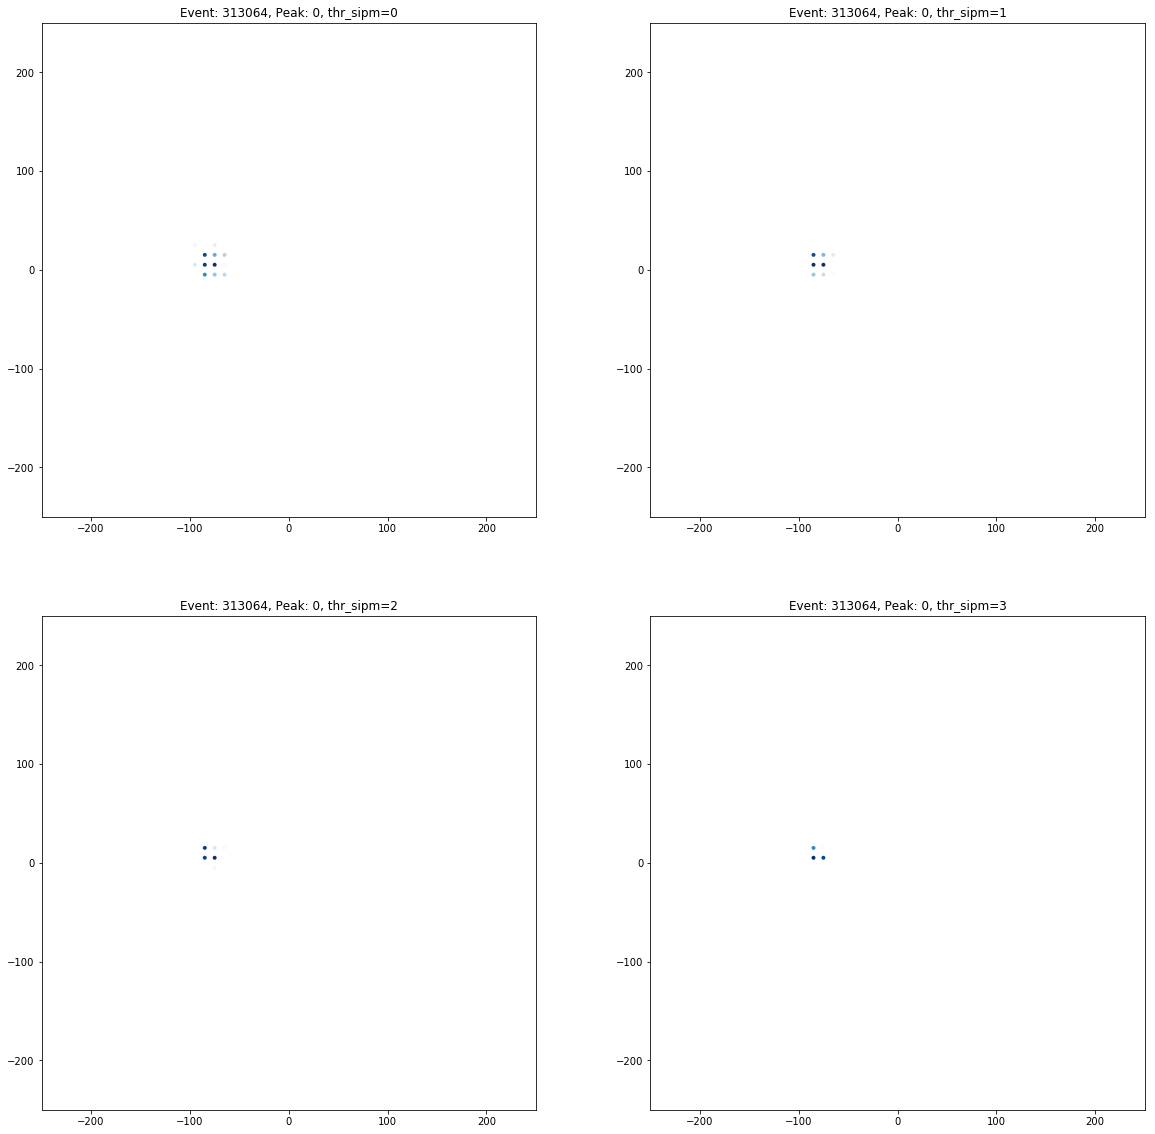

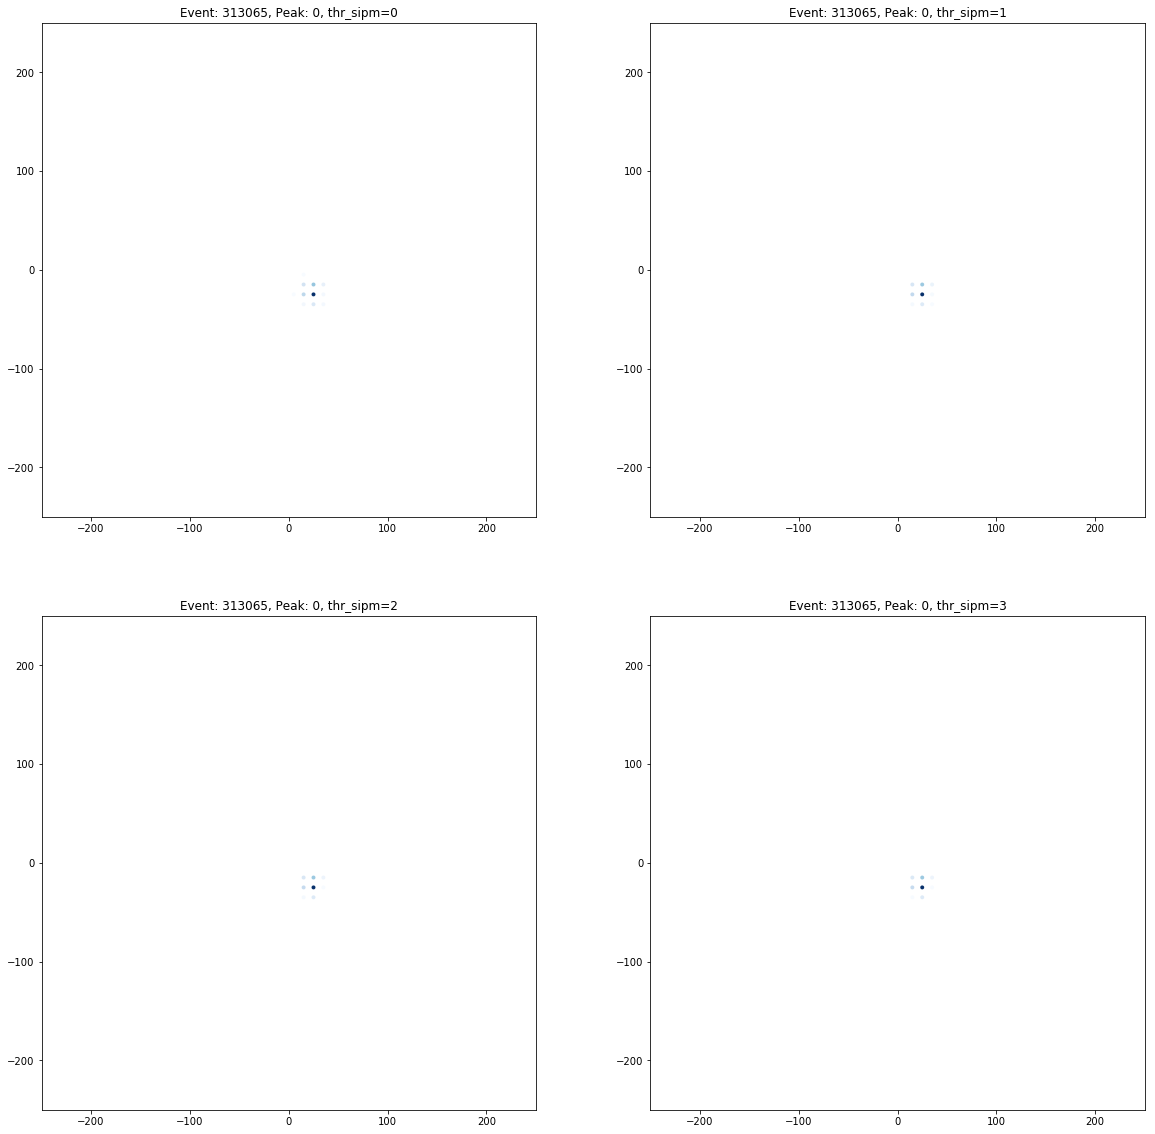

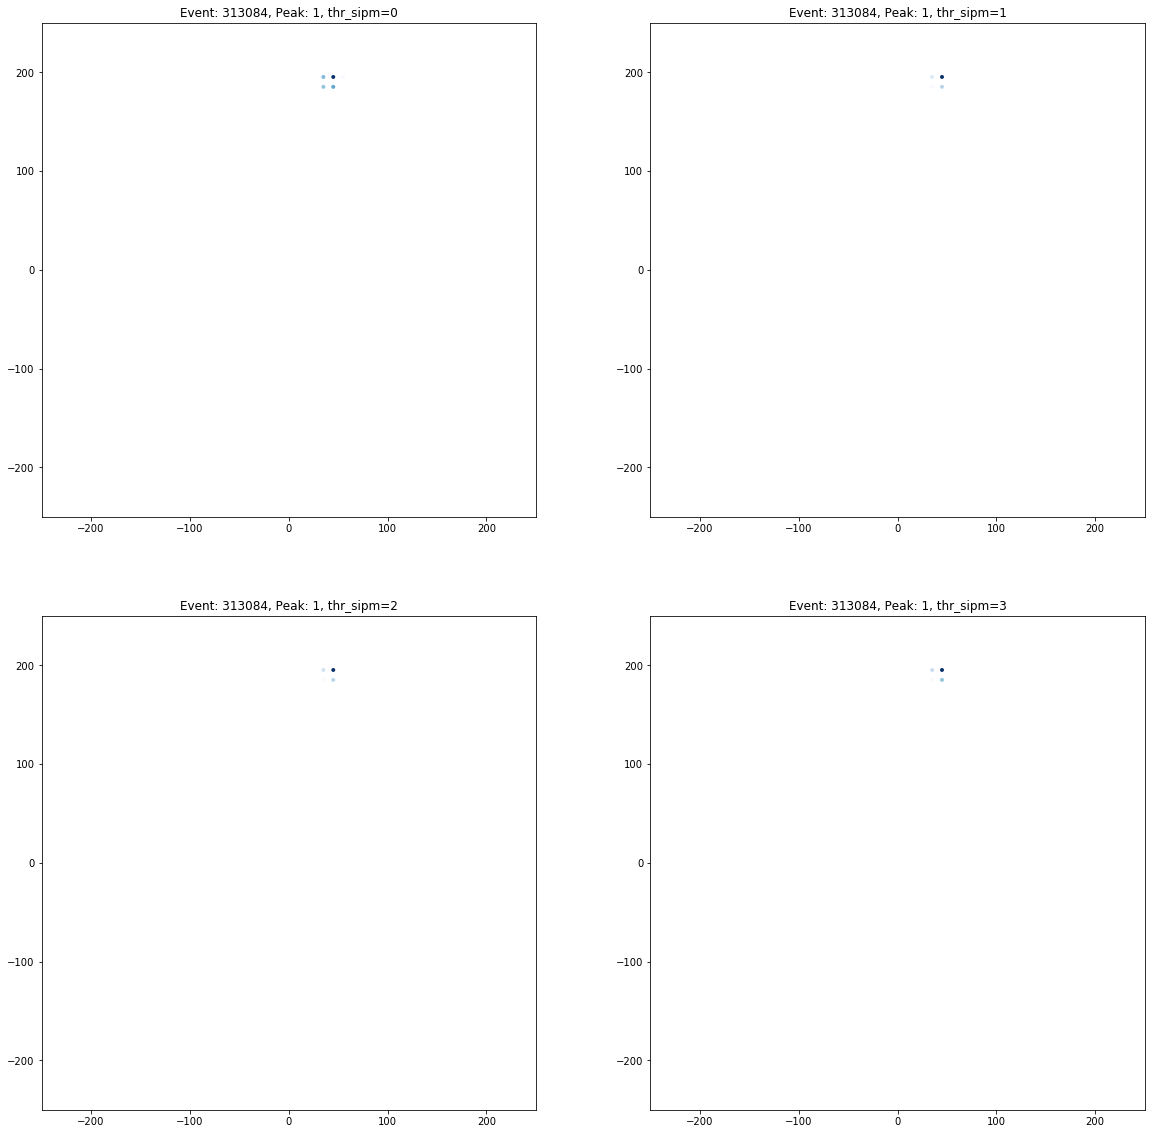

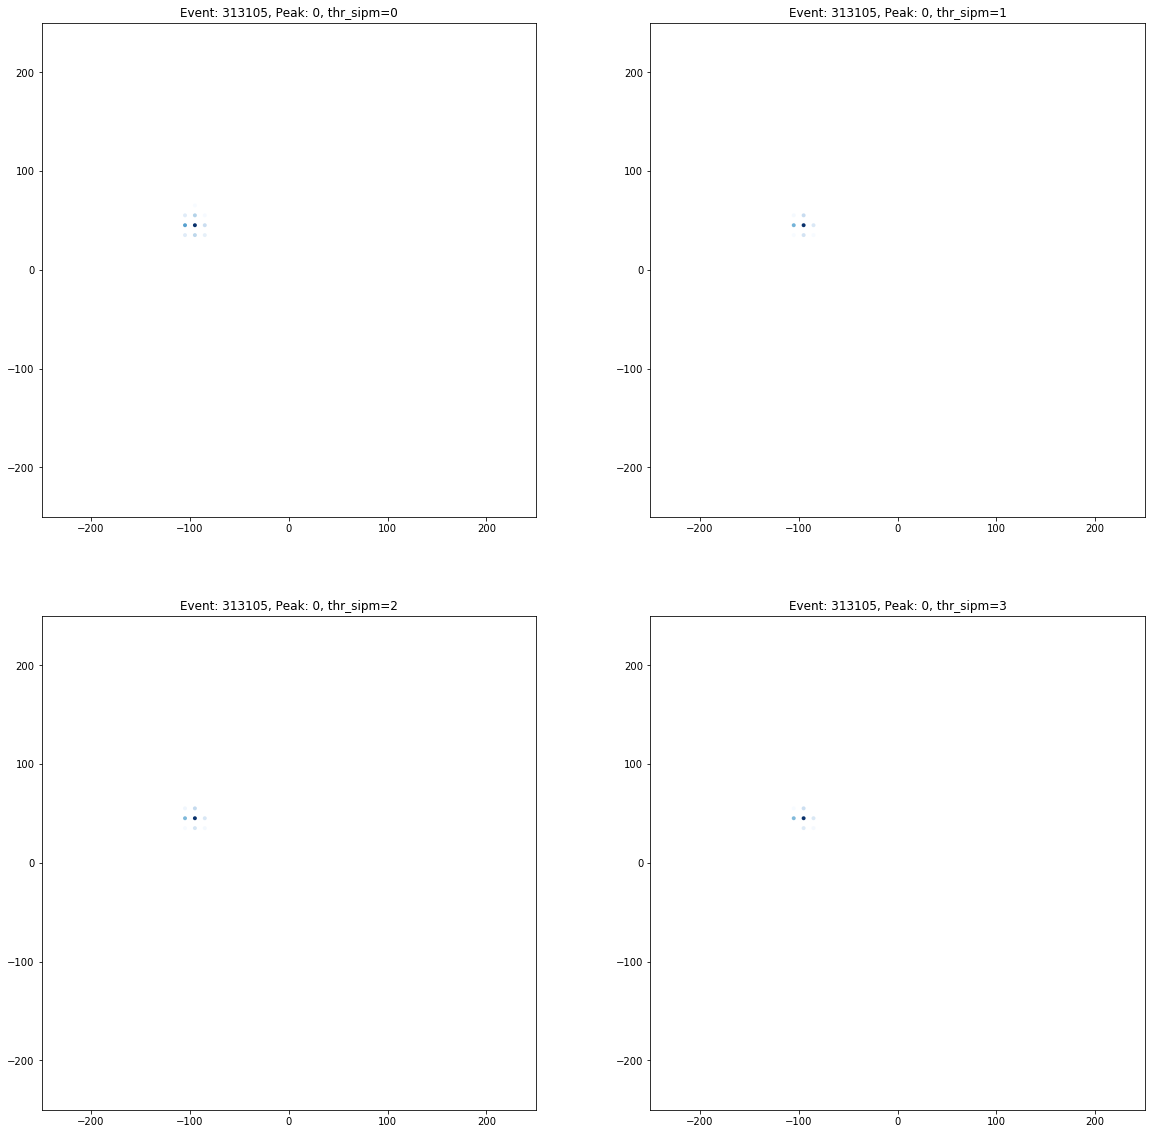

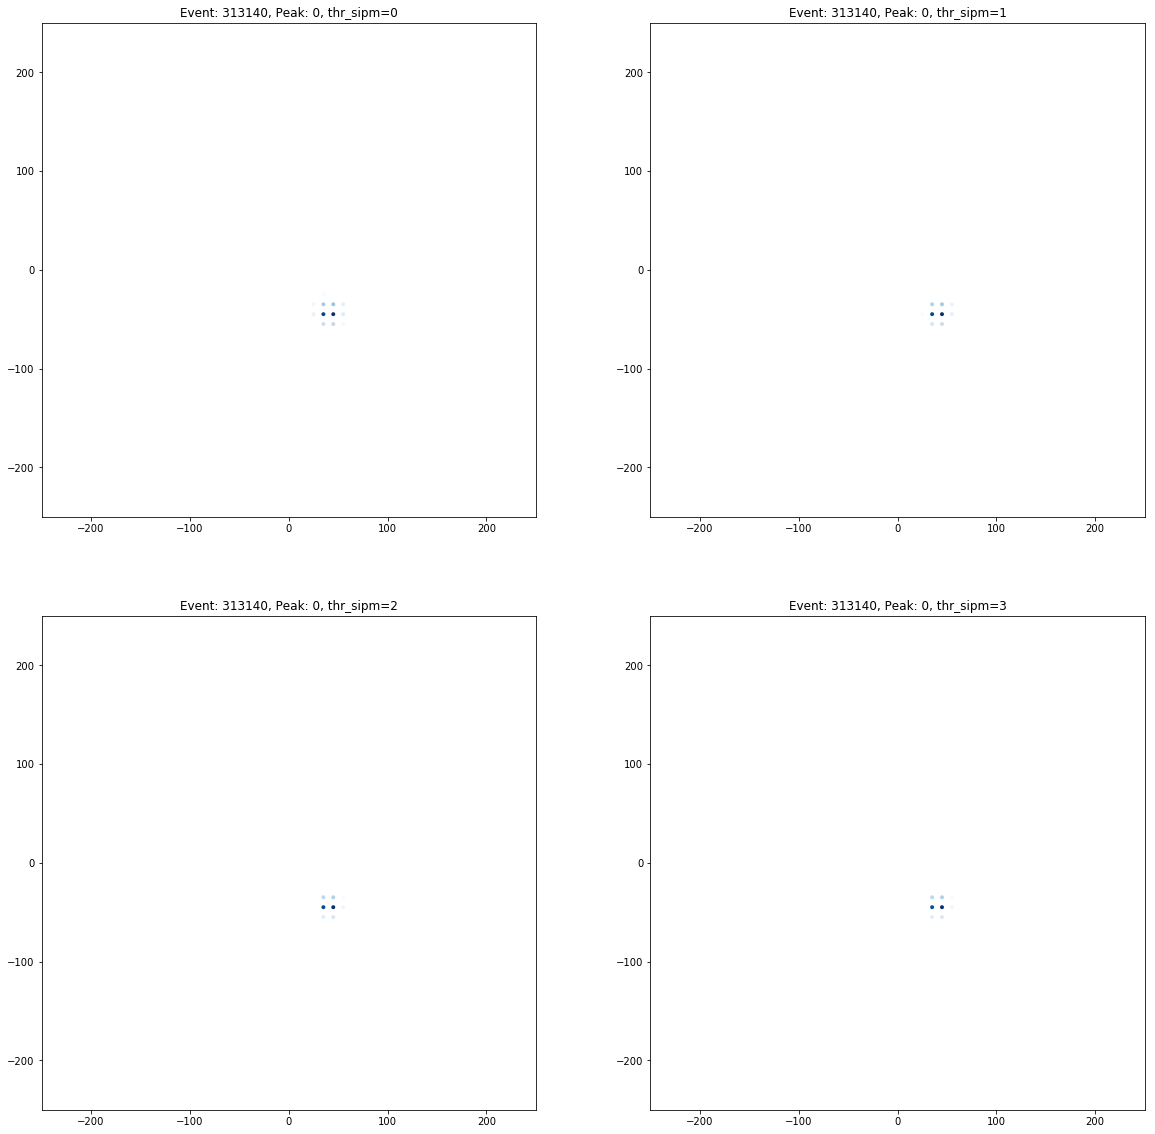

In [6]:
evs  = sample_events(10, rwf_path)
evis = evs - evs[0]
#irene.thr_sipm_s2=20
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        plt.figure(figsize=(20,20))
        subplot=221
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        for thr_sipm in range(4):
            irene.thr_sipm = thr_sipm
            sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt])
            s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)
            pn = np.array(list(s2si.peaks.keys())).max()
            plt.subplot(subplot)
            plot_s2si_peak_map(s2si.s2sid[pn], cmap='Blues', subplot=subplot, colorbar=False)
            plt.title('Event: ' + str(evt + evs[0]) + ', Peak: ' + str(pn) + ', thr_sipm=' + str(irene.thr_sipm))
            subplot+=1
        plt.show()
        print('======================================================================================================')

Even with the threshold set to 0, were are making a cut somewhere clearly beacuse we don't see little noisy SiPMs and in the s2si there are only a few SiPMs. That said, it looks like 3.5 pes is an excessively high threshold.

#### Look at baseline s2si in the waveform when there is no s2 (and preferably no s1 either), figure out avg value + some sigma and set threshold there?

In [7]:
irene.thr_sipm=3.5
def get_rid_of_peaks(wf, s12, buff=2*units.mus):
    for p in s12.peaks:
        (t0, t1) = s12.peaks[p].tmin_tmax
        t0 = np.floor(t0) - buff
        t1 = np.ceil(t1)  + buff
        i0 = int(t0 / units.mus)
        i1 = int(t1 / units.mus)
        return np.concatenate((wf[:i0], wf[i1:])) # may give index error

evs  = sample_events(-1, rwf_path,all_events=True)
evis = evs - evs[0]
avg_baseline = []
#irene.thr_sipm_s2=20
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt][active_sipm==1])
        s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)
        skip=False
        for p in s1.peaks:
            if s1.peaks[p].t[-1] > 500*units.mus: skip=True
        if not skip:
            wf = get_rid_of_peaks(sipmzs.mean(axis=0), s2)
            wf = wf[wf < 50*units.pes] # This should only happen if there is a real s2
            avg_baseline.append(wf.mean())

#### Avg signal in one sipm in one time bin NOT during an S2

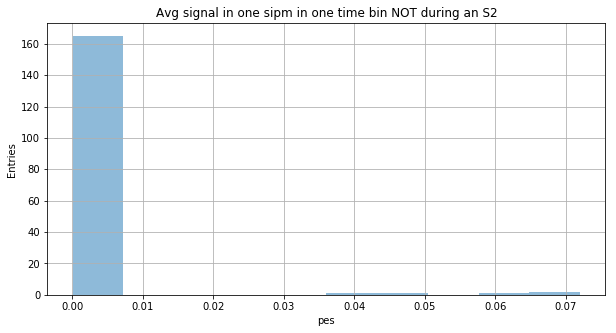

In [8]:
plt.figure(figsize=(10,5))
plt.hist(avg_baseline, alpha=.5)
plt.grid(True)
plt.title('Avg signal in one sipm in one time bin NOT during an S2')
plt.xlabel('pes')
plt.ylabel('Entries')
plt.show()

#### Quick look at avg waveforms

In [9]:
irene.thr_sipm=0
evs  = sample_events(-1, rwf_path,all_events=True)
evis = evs - evs[0]
avg_pre_s1 = np.zeros(300        , dtype=np.float32)
pre_s1     = np.zeros((len(active_sipm[active_sipm==1]), 300), dtype=np.float32)
pre_s1_tb  = []
evc = 0
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt][active_sipm==1])
        s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)

        # Skip all events that have a peak before 300 mus in the pmts
        skip=False
        if csum[:300].max() > .5: 
            continue           
        for s12 in [s1, s2]:
            for p in s12.peaks:
                if s12.peaks[p].t[0] < 300*units.mus: 
                    skip=True
                    break
        if skip: continue
        else: 
            pre_s1 += sipmzs[:,:300]
            avg_pre_s1 += pre_s1.mean(axis=0)
            pre_s1_tb.extend(sipmzs[:,:300].flatten())
            evc += 1
    
avg_pre_s1 /= evc
pre_s1 /= evc

Number of events: 147


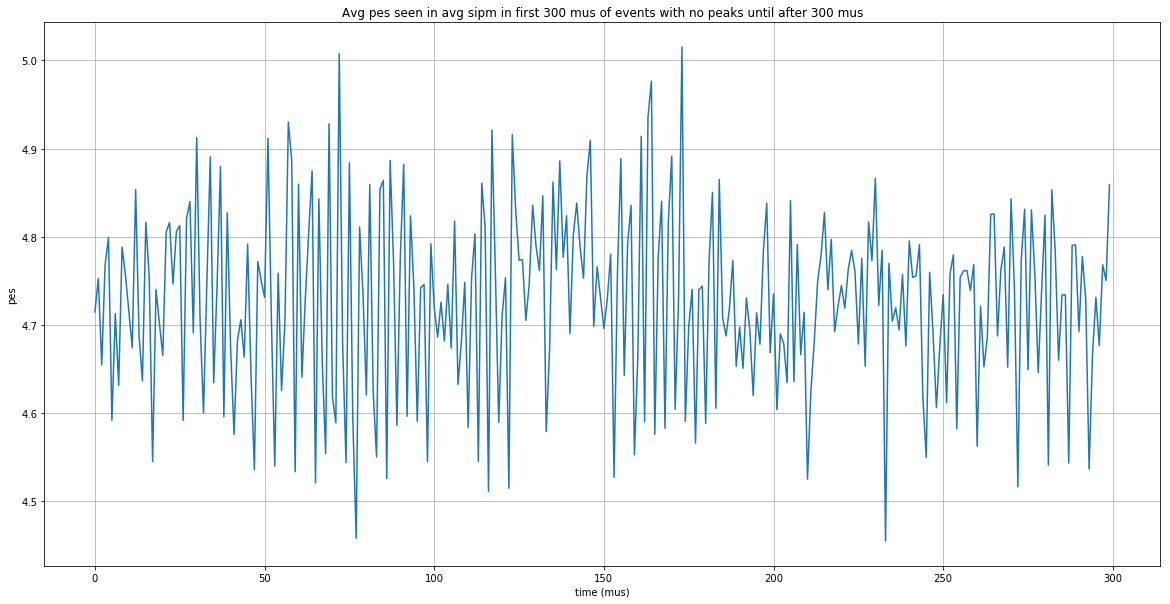

In [10]:
print('Number of events:', evc)
plt.figure(figsize=(20, 10))
plt.plot(np.arange(300), avg_pre_s1)
plt.grid(True)
plt.title('Avg pes seen in avg sipm in first 300 mus of events with no peaks until after 300 mus')
plt.ylabel('pes')
plt.xlabel('time (mus)')
plt.show()

Number of events: 147


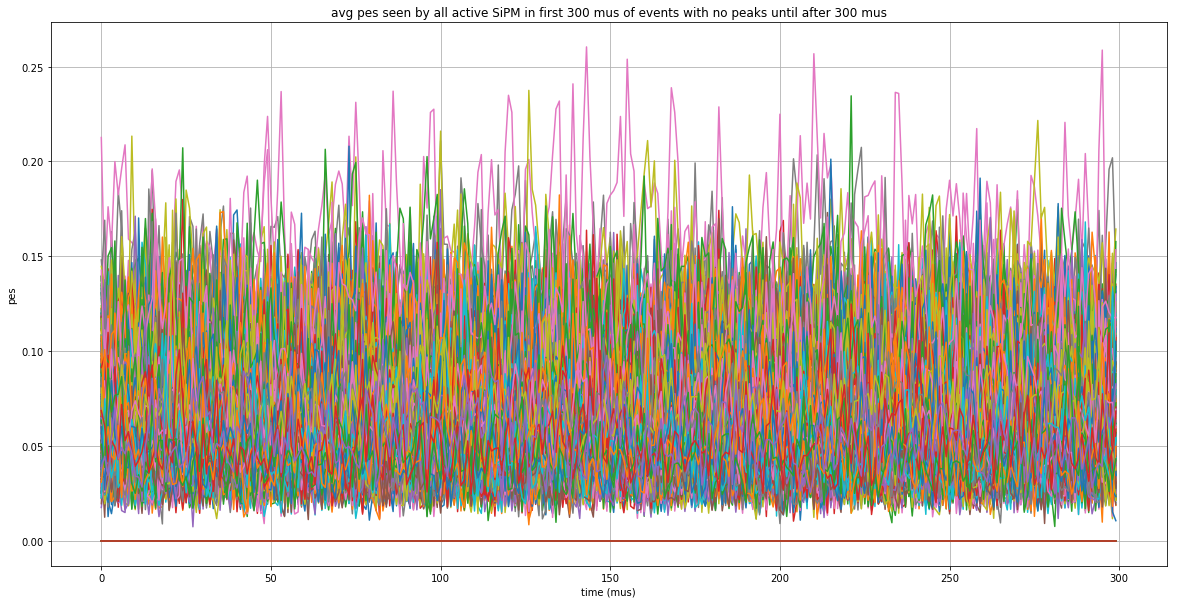

In [11]:
print('Number of events:', evc)
plt.figure(figsize=(20, 10))
for sipm in pre_s1:
    plt.plot(np.arange(300), sipm)
plt.grid(True)
plt.title('avg pes seen by all active SiPM in first 300 mus of events with no peaks until after 300 mus')
plt.ylabel('pes')
plt.xlabel('time (mus)')
plt.show()

#### All of this looks promising. But the analysis is not great because by taking the average waveform I am averaging out the noise I am looking for. I'm underestimating the noise. (Still at .05 pes is two orders of magnitude away from our 3.5 threshold)

N time bins: 78718500


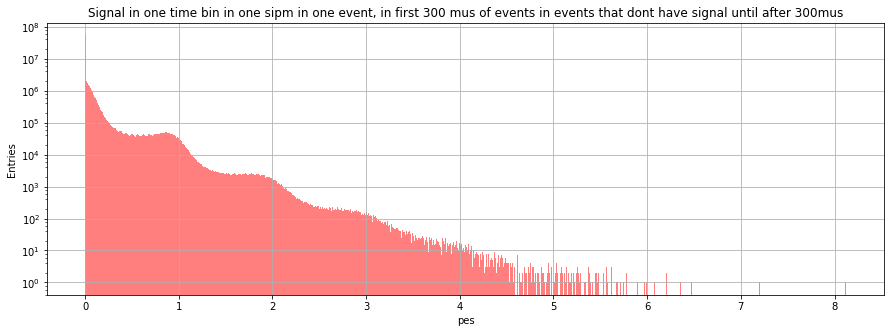

In [12]:
print('N time bins:', len(pre_s1_tb))
plt.figure(figsize=(15,5))
pre_s1_tb=np.array(pre_s1_tb)
plt.hist(pre_s1_tb, alpha=.5, bins=1000, color='red')
plt.grid(True)
plt.title('Signal in one time bin in one sipm in one event, in first 300 mus of events in events that dont have signal until after 300mus')
plt.xlabel('pes')
plt.ylabel('Entries')
plt.yscale('log')
#plt.xlim(0,2)
plt.show()

## Beautiful
The plot shows first:
That there is a 1/10^3 chance that if there is no signal detected by the PMTs there is a 1/10^3 chance an SiPM will record 1 pes+ and a 1/10^5 chance it will record 2 pes+ in one time bin. 

Second, the plot shows that our detector 